In [1]:
#Import Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os #operating system dependent modules of Python
import matplotlib.pyplot as plt #visualization
import seaborn as sns #visualization
%matplotlib inline
import itertools
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import warnings
warnings.filterwarnings("ignore")

In [2]:
nyc_data = pd.read_csv("train.csv", nrows = 500000)
nyc_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
test = pd.read_csv("test.csv")
test.dtypes
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [4]:
#replace 0's in coordinates with null values
coord = ['pickup_longitude','pickup_latitude', 
         'dropoff_longitude', 'dropoff_latitude']

for i in coord :
    nyc_data[i] = nyc_data[i].replace(0,np.nan)
    nyc_data    = nyc_data[nyc_data[i].notnull()]

#conver to date format
nyc_data["pickup_datetime"] = nyc_data["pickup_datetime"].astype(str).str.replace(" UTC","")
nyc_data["pickup_datetime"] = pd.to_datetime(nyc_data["pickup_datetime"],
                                             format="%Y-%m-%d %H:%M:%S")

test["pickup_datetime"] = test["pickup_datetime"].astype(str).str.replace(" UTC","")
test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"],
                                             format="%Y-%m-%d %H:%M:%S")
#extract year
nyc_data["year"]  = pd.DatetimeIndex(nyc_data["pickup_datetime"]).year
#extract month
nyc_data["month"] = pd.DatetimeIndex(nyc_data["pickup_datetime"]).month
nyc_data["month_name"] = nyc_data["month"].map({1:"JAN",2:"FEB",3:"MAR",
                                                4:"APR",5:"MAY",6:"JUN",
                                                7:"JUL",8:"AUG",9:"SEP",
                                                10:"OCT",11:"NOV",12:"DEC"
                                               })
#merge year month
nyc_data["month_year"] = nyc_data["year"].astype(str) + " - " + nyc_data["month_name"]
#extract day 
nyc_data["day"]        = nyc_data["pickup_datetime"].dt.day
#extract hour
nyc_data["hour"]        = nyc_data["pickup_datetime"].dt.hour 
nyc_data = nyc_data.sort_values(by = "pickup_datetime",ascending = False)

#Outlier treatment
#drop observations with passengers greater than 6 and equals 0
nyc_data = nyc_data[(nyc_data["passenger_count"] > 0 ) &
                    (nyc_data["passenger_count"] < 7) ]

#drop observations with fareamount  less than 0 and  greater than 99.99% percentile value.
nyc_data = nyc_data[ (nyc_data["fare_amount"] > 0 ) &
                     (nyc_data["fare_amount"]  <  
                      nyc_data["fare_amount"].quantile(.9999))]

#drop outlier observations in data
coords = ['pickup_longitude','pickup_latitude', 
          'dropoff_longitude', 'dropoff_latitude']
for i in coord  : 
    nyc_data = nyc_data[(nyc_data[i]   > nyc_data[i].quantile(.001)) & 
                        (nyc_data[i] < nyc_data[i].quantile(.999))]
    
nyc_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,month_name,month_year,day,hour
286276,2015-06-30 23:38:21.0000003,26.5,2015-06-30 23:38:21,-74.008385,40.711571,-73.884071,40.737385,5,2015,6,JUN,2015 - JUN,30,23
240182,2015-06-30 23:34:05.0000002,7.5,2015-06-30 23:34:05,-73.996719,40.742764,-73.991905,40.725853,1,2015,6,JUN,2015 - JUN,30,23
182743,2015-06-30 23:28:55.0000007,8.0,2015-06-30 23:28:55,-73.984734,40.748158,-73.983185,40.764431,1,2015,6,JUN,2015 - JUN,30,23
362807,2015-06-30 23:26:21.0000001,16.0,2015-06-30 23:26:21,-73.979385,40.682659,-73.925461,40.669498,2,2015,6,JUN,2015 - JUN,30,23
350061,2015-06-30 23:22:46.0000006,10.0,2015-06-30 23:22:46,-73.984718,40.754299,-73.966904,40.772480,1,2015,6,JUN,2015 - JUN,30,23


#Finding distance based on longitude and latitude

The Haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.

dlon = dropoff_lon - pickup_lon

dlat = dropoff_lat - pickup_lat

a = (sin(dlat/2))^2 + cos(dropoff_lat) * cos(pickup_lat) * (sin(dlon/2))^2

c = 2 * atan2(sqrt(a), sqrt(1-a))

d = R * c (where R is the radius of the Earth)

In [5]:
#radius of earth in kilometers
R = 6373.0

pickup_lat  = np.radians(nyc_data["pickup_latitude"])
pickup_lon  = np.radians(nyc_data["pickup_longitude"])
dropoff_lat = np.radians(nyc_data["dropoff_latitude"])
dropoff_lon = np.radians(nyc_data["dropoff_longitude"])

dist_lon = dropoff_lon - pickup_lon
dist_lat = dropoff_lat - pickup_lat

#Formula
a = (np.sin(dist_lat/2))**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * (np.sin(dist_lon/2))**2 
c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) ) 
d = R * c #(where R is the radius of the Earth)

nyc_data["trip_distance_km"] = d

#create new variable log of distance
nyc_data["log_trip_ditance"] = np.log(nyc_data["trip_distance_km"])

nyc_data[coord + ["trip_distance_km"]].head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
286276,-74.008385,40.711571,-73.884071,40.737385,10.865387
240182,-73.996719,40.742764,-73.991905,40.725853,1.924224
182743,-73.984734,40.748158,-73.983185,40.764431,1.814796
362807,-73.979385,40.682659,-73.925461,40.669498,4.778674
350061,-73.984718,40.754299,-73.966904,40.772480,2.518330


Distribution of Haversine Distance in Kilometers

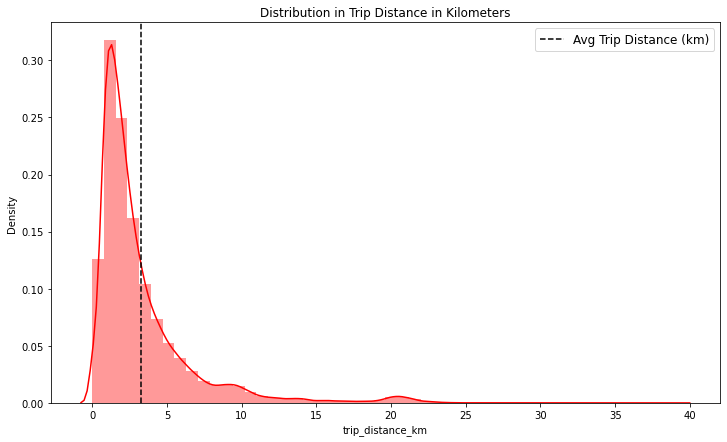

In [6]:
plt.figure(figsize = (12,7))
sns.distplot(nyc_data["trip_distance_km"],color = "r")
plt.axvline(nyc_data["trip_distance_km"].mean(),color = "k",
            linestyle = "dashed",label = "Avg Trip Distance (km)")
plt.title("Distribution in Trip Distance in Kilometers")
plt.legend(loc = "best",prop = {"size" : 12})
plt.show()

Total Trips, Passengers and Fare Amount per Year

In [7]:
yearly_analysis  = nyc_data.groupby("year").agg({"key":"count",
                                                 "fare_amount":"sum",
                                                 "passenger_count":"sum",
                                                 "trip_distance_km" : "sum"}).reset_index()
#aggregating by year
yearly_analysis = yearly_analysis.rename(columns = {"key" : "trip_count"})

#plotting trips ,passengers and fare amount by year
def plotting(column) : 
    tracer = go.Bar(x= yearly_analysis["year"],y = yearly_analysis[column],
                    marker = dict(line = dict(width = 1)),
                    name = column
                   )
    return tracer

#layout
layout = go.Layout(dict(title = "Total trips, Passengers, Distance and Fare Amount per Year",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "Year",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "Count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
    
data = [plotting("trip_count"),plotting("passenger_count"),
        plotting("trip_distance_km"),plotting("fare_amount")]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)

Trend in Trips by Hour of Day

In [8]:
trips_hr = nyc_data["hour"].value_counts().reset_index()
trips_hr.columns = ["hour","count"]
trips_hr = trips_hr.sort_values(by = "hour",ascending = True)

trace = go.Scatter(x = trips_hr["hour"],y = trips_hr["count"],
                   mode = "markers+lines",
                  marker = dict(color = "red",size = 9,
                                line = dict(color = "black",width =2)))
#layout
layout = go.Layout(dict(title = "Trend in Trips by Hour of Day",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "Hour",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "Count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )

fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

In [9]:
#replace 0's in coordinates with null values
coord = ['pickup_longitude','pickup_latitude', 
         'dropoff_longitude', 'dropoff_latitude']

for i in coord :
    nyc_data[i] = nyc_data[i].replace(0,np.nan)
    nyc_data    = nyc_data[nyc_data[i].notnull()]


In [10]:
# Data Cleaning 
# ● Handling the missing values
# In the analysis phase we notice there is a few missing value, therefore we decide to eliminate them all. 

In [11]:
#Find wether there is index with null vlaue
pd.isnull(np.nan) 

True

In [12]:
# Delete the index with null value
nyc_data = nyc_data.dropna()
print(nyc_data)

                                key  fare_amount     pickup_datetime  \
286276  2015-06-30 23:38:21.0000003         26.5 2015-06-30 23:38:21   
240182  2015-06-30 23:34:05.0000002          7.5 2015-06-30 23:34:05   
182743  2015-06-30 23:28:55.0000007          8.0 2015-06-30 23:28:55   
362807  2015-06-30 23:26:21.0000001         16.0 2015-06-30 23:26:21   
350061  2015-06-30 23:22:46.0000006         10.0 2015-06-30 23:22:46   
...                             ...          ...                 ...   
76195   2009-01-01 01:21:54.0000002          4.9 2009-01-01 01:21:54   
124445  2009-01-01 00:47:26.0000007          5.4 2009-01-01 00:47:26   
82469   2009-01-01 00:41:00.0000003          6.2 2009-01-01 00:41:00   
124750  2009-01-01 00:35:03.0000001         16.5 2009-01-01 00:35:03   
297860  2009-01-01 00:31:32.0000001         11.8 2009-01-01 00:31:32   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
286276        -74.008385        40.711571         -73.884071   
240182 

In [13]:
#a dictionary with NYC coordinates from test data that will be used in deleting outliers
coordinates = {'min_long': min(nyc_data.pickup_longitude.min(), nyc_data.dropoff_longitude.min()),
              'max_long': max(nyc_data.pickup_longitude.max(), nyc_data.dropoff_longitude.max()),
              'min_lat': min(nyc_data.pickup_latitude.min(), nyc_data.dropoff_latitude.min()),
              'max_lat' : min(nyc_data.pickup_latitude.max(), nyc_data.dropoff_latitude.max()),}

In [14]:
#● Handling the outliers
#We did notice in the previous section that our data has too much outliers (not realistic data) which will affect our model negatively

In [15]:
#drop observations with passengers greater than 6 and equals 0
nyc_data = nyc_data[(nyc_data["passenger_count"] > 0 ) &
                    (nyc_data["passenger_count"] < 7) ]

In [16]:
#drop observations with fareamount  less than 0 and  greater than 99.99% percentile value.
nyc_data = nyc_data[ (nyc_data["fare_amount"] > 0 ) &
                     (nyc_data["fare_amount"]  <  
                      nyc_data["fare_amount"].quantile(.9999))]

In [17]:
#drop outlier observations in data
coords = ['pickup_longitude','pickup_latitude', 
          'dropoff_longitude', 'dropoff_latitude']
for i in coord  : 
    nyc_data = nyc_data[(nyc_data[i]   > nyc_data[i].quantile(.001)) & 
                        (nyc_data[i] < nyc_data[i].quantile(.999))]


In [18]:
nyc_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,month_name,month_year,day,hour,trip_distance_km,log_trip_ditance
286276,2015-06-30 23:38:21.0000003,26.5,2015-06-30 23:38:21,-74.008385,40.711571,-73.884071,40.737385,5,2015,6,JUN,2015 - JUN,30,23,10.865387,2.385582
240182,2015-06-30 23:34:05.0000002,7.5,2015-06-30 23:34:05,-73.996719,40.742764,-73.991905,40.725853,1,2015,6,JUN,2015 - JUN,30,23,1.924224,0.654523
182743,2015-06-30 23:28:55.0000007,8.0,2015-06-30 23:28:55,-73.984734,40.748158,-73.983185,40.764431,1,2015,6,JUN,2015 - JUN,30,23,1.814796,0.595973
362807,2015-06-30 23:26:21.0000001,16.0,2015-06-30 23:26:21,-73.979385,40.682659,-73.925461,40.669498,2,2015,6,JUN,2015 - JUN,30,23,4.778674,1.564163
350061,2015-06-30 23:22:46.0000006,10.0,2015-06-30 23:22:46,-73.984718,40.754299,-73.966904,40.772480,1,2015,6,JUN,2015 - JUN,30,23,2.518330,0.923596


In [19]:
#● Generating new features (feature generation)
#Extracting date and time
#Using the date attribute which is not useful in this format we will transform 5 more attributes which are: Year, Month, Day, Day of The week, and hour.

In [20]:
#conver to date format
nyc_data["pickup_datetime"] = nyc_data["pickup_datetime"].astype(str).str.replace(" UTC","")
nyc_data["pickup_datetime"] = pd.to_datetime(nyc_data["pickup_datetime"],
                                             format="%Y-%m-%d %H:%M:%S")

In [21]:
#extract year
nyc_data["year"]  = pd.DatetimeIndex(nyc_data["pickup_datetime"]).year
#extract month
nyc_data["month"] = pd.DatetimeIndex(nyc_data["pickup_datetime"]).month
nyc_data["month_name"] = nyc_data["month"].map({1:"JAN",2:"FEB",3:"MAR",
                                                4:"APR",5:"MAY",6:"JUN",
                                                7:"JUL",8:"AUG",9:"SEP",
                                                10:"OCT",11:"NOV",12:"DEC"
                                               })
#merge year month
nyc_data["month_year"] = nyc_data["year"].astype(str) + " - " + nyc_data["month_name"]
#extract day 
nyc_data["day"]        = nyc_data["pickup_datetime"].dt.day
#extract hour
nyc_data["hour"]        = nyc_data["pickup_datetime"].dt.hour 
nyc_data = nyc_data.sort_values(by = "pickup_datetime",ascending = False)


In [22]:
#Airport pickup and dropoff
#As mentionned earlier, NYC has 3 airports. We all now that taxis pick and drop passangers frequently from these kind of locations. So for each airport we will add 2 columnes: pick_up and drop_off.


In [23]:
#nyc_airports coordinates
nyc_airports={'JFK':{'min_lng':-73.835,
                     'min_lat':40.619,
                     'max_lng':-73.740, 
                     'max_lat':40.665},
              
              'EWR':{'min_lng':-74.192,
                     'min_lat':40.670, 
                     'max_lng':-74.153, 
                     'max_lat':40.708},
              
        'LaGuardia':{'min_lng':-73.889, 
                     'min_lat':40.766, 
                     'max_lng':-73.855, 
                     'max_lat':40.793}
                }


In [24]:
# a function to assign 1 if we have a pick up or drop off from an airport
def Airport(latitude, longitude, airport_name):
    if (latitude>=nyc_airports[airport_name]['min_lat'] and
      latitude<=nyc_airports[airport_name]['max_lat'] and
      longitude>=nyc_airports[airport_name]['min_lng'] and
      longitude<=nyc_airports[airport_name]['max_lng']):
        return 1
    else:
        return 0

In [25]:
nyc_data['pick_up_JFK']=nyc_data.apply(lambda row:Airport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
nyc_data['dropoff_JFK']=nyc_data.apply(lambda row:Airport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)
nyc_data['pickup_EWR']=nyc_data.apply(lambda row:Airport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
nyc_data['dropoff_EWR']=nyc_data.apply(lambda row:Airport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
nyc_data['pickup_la_guardia']=nyc_data.apply(lambda row:Airport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
nyc_data['dropoff_la_guardia']=nyc_data.apply(lambda row:Airport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)
nyc_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,...,day,hour,trip_distance_km,log_trip_ditance,pick_up_JFK,dropoff_JFK,pickup_EWR,dropoff_EWR,pickup_la_guardia,dropoff_la_guardia
286276,2015-06-30 23:38:21.0000003,26.5,2015-06-30 23:38:21,-74.008385,40.711571,-73.884071,40.737385,5,2015,6,...,30,23,10.865387,2.385582,0,0,0,0,0,0
240182,2015-06-30 23:34:05.0000002,7.5,2015-06-30 23:34:05,-73.996719,40.742764,-73.991905,40.725853,1,2015,6,...,30,23,1.924224,0.654523,0,0,0,0,0,0
182743,2015-06-30 23:28:55.0000007,8.0,2015-06-30 23:28:55,-73.984734,40.748158,-73.983185,40.764431,1,2015,6,...,30,23,1.814796,0.595973,0,0,0,0,0,0
362807,2015-06-30 23:26:21.0000001,16.0,2015-06-30 23:26:21,-73.979385,40.682659,-73.925461,40.669498,2,2015,6,...,30,23,4.778674,1.564163,0,0,0,0,0,0
350061,2015-06-30 23:22:46.0000006,10.0,2015-06-30 23:22:46,-73.984718,40.754299,-73.966904,40.772480,1,2015,6,...,30,23,2.518330,0.923596,0,0,0,0,0,0


In [26]:
#Finding distance based on longitude and latitude
#The Haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.


In [27]:
#radius of earth in kilometers
R = 6373.0

pickup_lat  = np.radians(nyc_data["pickup_latitude"])
pickup_lon  = np.radians(nyc_data["pickup_longitude"])
dropoff_lat = np.radians(nyc_data["dropoff_latitude"])
dropoff_lon = np.radians(nyc_data["dropoff_longitude"])

dist_lon = dropoff_lon - pickup_lon
dist_lat = dropoff_lat - pickup_lat

In [28]:
#Formula
a = (np.sin(dist_lat/2))**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * (np.sin(dist_lon/2))**2 
c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) ) 
d = R * c #(where R is the radius of the Earth)

nyc_data["trip_distance_km"] = d

In [29]:
#create new variable log of distance
nyc_data["log_trip_ditance"] = np.log(nyc_data["trip_distance_km"])

nyc_data[coord + ["trip_distance_km"]].head()


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
286276,-74.008385,40.711571,-73.884071,40.737385,10.865387
240182,-73.996719,40.742764,-73.991905,40.725853,1.924224
182743,-73.984734,40.748158,-73.983185,40.764431,1.814796
362807,-73.979385,40.682659,-73.925461,40.669498,4.778674
350061,-73.984718,40.754299,-73.966904,40.772480,2.518330


In [30]:
#● Data Transformation
#Normalization
#We are trying to reduce the size of our data so our model train faster

In [31]:
nyc_data.year = (nyc_data.year - 2009)
max_year = nyc_data.year.max()
nyc_data.month = nyc_data.month + nyc_data.year*12
nyc_data.year = nyc_data.year/max_year
max_month = nyc_data.month.max()
nyc_data.month = nyc_data.month/max_month
max_day = nyc_data.day.max()
nyc_data.day = nyc_data.day/max_day
max_hour = nyc_data.hour.max()
nyc_data.hour = nyc_data.hour / max_hour
nyc_data.pickup_latitude = coordinates['max_lat'] - nyc_data.pickup_latitude
nyc_data.dropoff_latitude = coordinates['max_lat'] - nyc_data.dropoff_latitude
nyc_data.pickup_longitude = coordinates['max_long'] - nyc_data.pickup_longitude
nyc_data.dropoff_longitude = coordinates['max_long'] - nyc_data.dropoff_longitude

In [32]:
display(nyc_data)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,...,day,hour,trip_distance_km,log_trip_ditance,pick_up_JFK,dropoff_JFK,pickup_EWR,dropoff_EWR,pickup_la_guardia,dropoff_la_guardia
286276,2015-06-30 23:38:21.0000003,26.5,2015-06-30 23:38:21,0.585693,0.131414,0.461379,0.105600,5,1.0,1.000000,...,0.967742,1.000000,10.865387,2.385582,0,0,0,0,0,0
240182,2015-06-30 23:34:05.0000002,7.5,2015-06-30 23:34:05,0.574027,0.100221,0.569213,0.117132,1,1.0,1.000000,...,0.967742,1.000000,1.924224,0.654523,0,0,0,0,0,0
182743,2015-06-30 23:28:55.0000007,8.0,2015-06-30 23:28:55,0.562042,0.094827,0.560493,0.078554,1,1.0,1.000000,...,0.967742,1.000000,1.814796,0.595973,0,0,0,0,0,0
362807,2015-06-30 23:26:21.0000001,16.0,2015-06-30 23:26:21,0.556693,0.160326,0.502769,0.173487,2,1.0,1.000000,...,0.967742,1.000000,4.778674,1.564163,0,0,0,0,0,0
350061,2015-06-30 23:22:46.0000006,10.0,2015-06-30 23:22:46,0.562026,0.088686,0.544212,0.070505,1,1.0,1.000000,...,0.967742,1.000000,2.518330,0.923596,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76195,2009-01-01 01:21:54.0000002,4.9,2009-01-01 01:21:54,0.529118,0.128088,0.539470,0.133631,4,0.0,0.012821,...,0.032258,0.043478,1.068598,0.066348,0,0,0,0,0,0
124445,2009-01-01 00:47:26.0000007,5.4,2009-01-01 00:47:26,0.564632,0.093414,0.553342,0.101034,1,0.0,0.012821,...,0.032258,0.000000,1.274181,0.242304,0,0,0,0,0,0
82469,2009-01-01 00:41:00.0000003,6.2,2009-01-01 00:41:00,0.571510,0.091977,0.563125,0.092408,2,0.0,0.012821,...,0.032258,0.000000,0.708168,-0.345073,0,0,0,0,0,0
124750,2009-01-01 00:35:03.0000001,16.5,2009-01-01 00:35:03,0.569246,0.104571,0.580807,0.159659,1,0.0,0.012821,...,0.032258,0.000000,6.204476,1.825271,0,0,0,0,0,0


In [33]:
#Discretization
#We are going to devide fare_amount to five levels

#max_fare = nyc_data.fare_amount.max()
#min_fare = nyc_data.fare_amount.min()
#W=(max_fare-min_fare)/5

#for i in nyc_data.fare_amount:
   # if(i<W):
      #  nyc_data.fare_amount[i]= 0
   # if(i>=W and i<2*W):
     #   nyc_data.fare_amount[i]= 1
  #  if(i>=2*W and i<3*W):
      #  nyc_data.fare_amount[i]= 2
   # if(i>=3*W and i<4*W):
     #   nyc_data.fare_amount[i]= 3
   # if(i>=4*W and i <5*W):
      #  nyc_data.fare_amount[i]= 4
   # else:
     #   nyc_data.fare_amount[i]= 5


In [34]:
#● Feature Analysis:
# Feature importance

In [35]:
# We are going to caculate the covariance between fare_amount and trip_distance_km
result= np.cov(nyc_data.fare_amount,nyc_data.trip_distance_km)

In [36]:
print(result)

[[73.81463067 25.04145223]
 [25.04145223 10.92728395]]


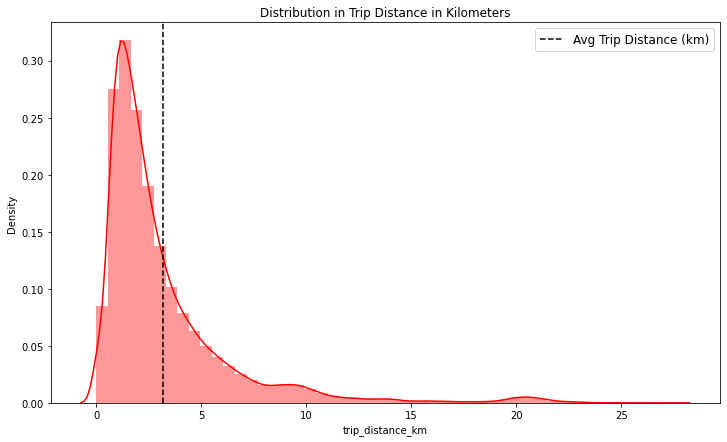

In [37]:
#● Skewed Data:
#Showing Distribution of Haversine Distance in Kilometers
plt.figure(figsize = (12,7))
sns.distplot(nyc_data["trip_distance_km"],color = "r")
plt.axvline(nyc_data["trip_distance_km"].mean(),color = "k",
            linestyle = "dashed",label = "Avg Trip Distance (km)")
plt.title("Distribution in Trip Distance in Kilometers")
plt.legend(loc = "best",prop = {"size" : 12})
plt.show()

In [38]:
#Data Reduction

In [39]:
# We have cacualted new avaible attibute with orginal attibutes, therefore, the old one is no more useful, we dicided to reduc them
#by  Dimensionality reduction,

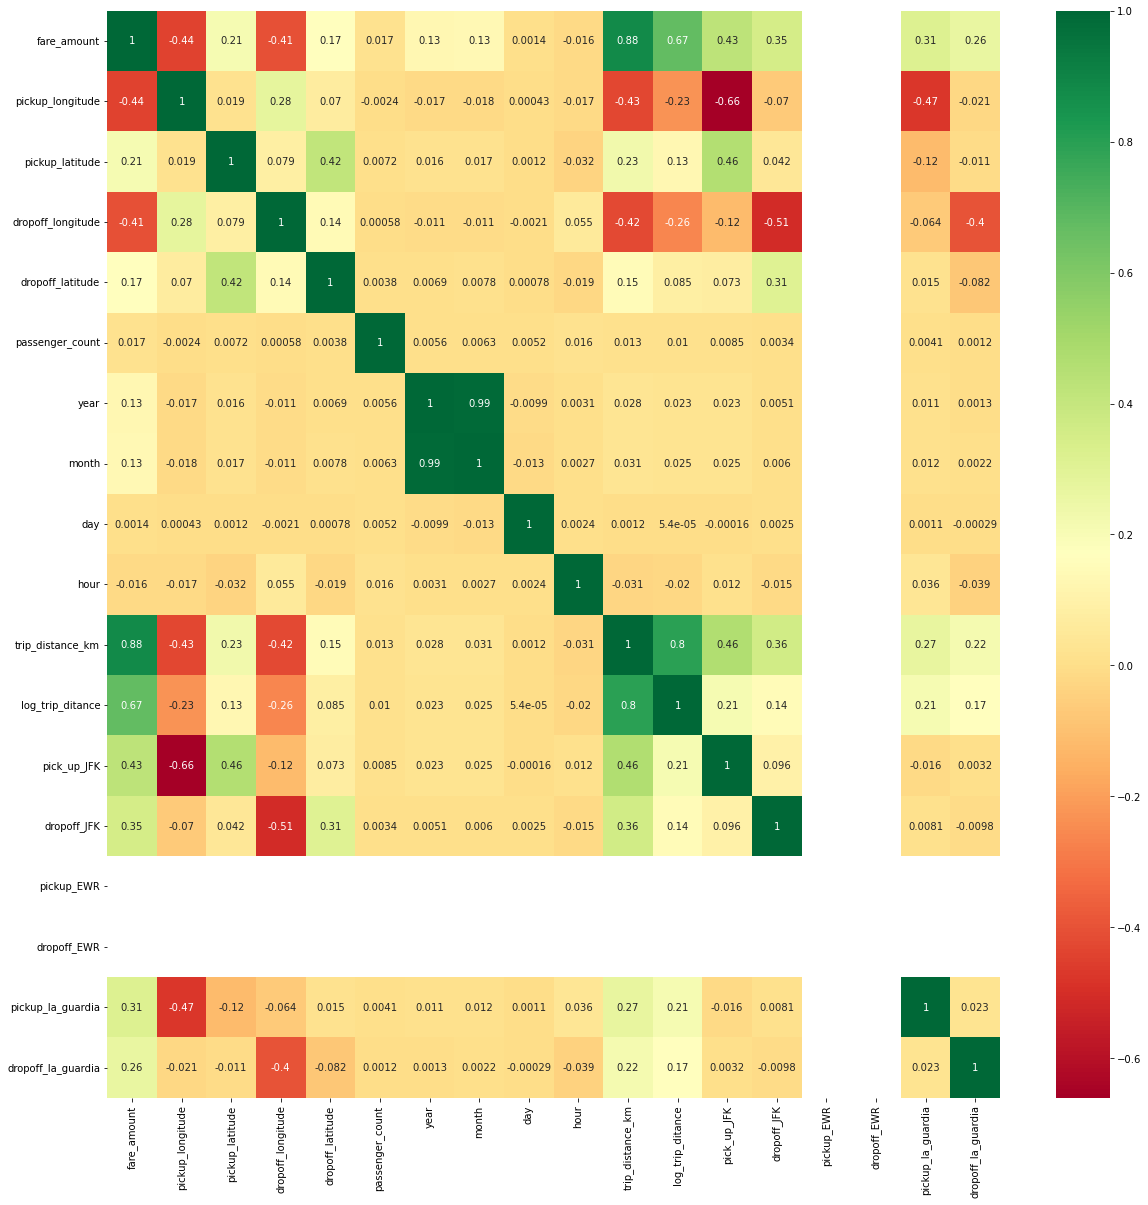

In [40]:
import seaborn as sns
from matplotlib import pyplot as plt
#get correlations of each features in dataset
corrmat = nyc_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(nyc_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [41]:
# From Correlation Matrix with Heatmap, we can find the pickup_Longtitude and Dropoff_Longtitude have more deep red cololer whoitch means less relationship
# We deveide to reduce them


In [42]:
from sklearn.model_selection import train_test_split
x = nyc_data.drop(columns = ['fare_amount'])
y = nyc_data[['fare_amount']]
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.1, random_state=0)
display(X_test[['trip_distance_km']])

,trip_distance_km
21738,6.563800
133110,3.287741
460178,4.140569
486675,0.206111
15898,1.082777
...,...
89182,1.730899
373834,20.952873
211817,3.097969
470417,1.259424


In [43]:
from sklearn.linear_model import LinearRegression
LRmodel = LinearRegression(normalize = True)
LRmodel.fit(X_train[['trip_distance_km']], Y_train[['fare_amount']])
print(LRmodel.score(X_test[['trip_distance_km']], Y_test[['fare_amount']]))

0.7804300890194287


In [44]:
prediction = np.round(LRmodel.predict(X_test[['trip_distance_km']]),2)
dfp = pd.DataFrame (prediction, columns = ['fare'])
dfp.head()

,fare
0,18.68
1,11.17
2,13.12
3,4.11
4,6.12


In [45]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, prediction))
rmse

4.018618165918405

In [46]:
Submission = pd.DataFrame(data = prediction, columns = ['fare_amount'])
Submission['trip_distance_km'] = nyc_data['trip_distance_km']
Submission = Submission[['trip_distance_km','fare_amount']]
Submission.set_index('trip_distance_km', inplace = True)
display(Submission)

,fare_amount
trip_distance_km,
1.031088,18.68
8.452786,11.17
1.389961,13.12
2.800149,4.11
1.999784,6.12
...,...
2.731259,7.60
1.597997,51.65
4.880944,10.73


In [47]:
Submission.to_csv('Submission.csv')

In [48]:
from sklearn.neighbors import KNeighborsRegressor

In [49]:
KNN = KNeighborsRegressor(n_neighbors = 100)

In [50]:
KNN.fit(X_train[['trip_distance_km']], Y_train[['fare_amount']])

KNeighborsRegressor(n_neighbors=100)

In [51]:
KNN.score(X_test[['trip_distance_km']], Y_test[['fare_amount']])

0.7953896071111363

In [52]:
prediction2 = KNN.predict(X_test[['trip_distance_km']])
prediction2

array([[18.6963],
       [10.9905],
       [13.2854],
       ...,
       [10.992 ],
       [ 6.486 ],
       [ 5.923 ]])

In [53]:
rmse2 = np.sqrt(mean_squared_error(Y_test, prediction2))
rmse2

3.8794007296150395

In [54]:
Submission2 = pd.DataFrame(data = prediction2, columns = ['fare_amount'])
Submission2['trip_distance_km'] = nyc_data['trip_distance_km']
Submission2 = Submission2[['trip_distance_km','fare_amount']]
Submission2.set_index('trip_distance_km', inplace = True)
display(Submission2)

,fare_amount
trip_distance_km,
1.031088,18.6963
8.452786,10.9905
1.389961,13.2854
2.800149,5.9330
1.999784,5.9930
...,...
2.731259,7.9680
1.597997,52.4416
4.880944,10.9920
